In [1]:
%load_ext lab_black

In [2]:
# Import all the necessary packages
import pandas as pd
import numpy as np

import statsmodels.api as sm
import scipy.stats as st

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

import json
import requests
import yaml
from twython import Twython
from twython import Twython, TwythonError

from pandas import json_normalize

from datetime import datetime
from dateutil import parser

In [105]:
dorsey = pd.read_csv("dorsey.csv")
twitter = pd.read_csv("TWTR.csv")

C:\Users\Amalia\anaconda3\envs\dstoolkit\lib\site-packages\IPython\core\interactiveshell.py:3417: DtypeWarning: Columns (351,352,354,355,357,358,359,360,361) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
dorsey.head(5)

,created_at,id,id_str,full_text,truncated,display_text_range,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,...,withheld_copyright,withheld_in_countries,retweeted_status.withheld_scope,retweeted_status.withheld_copyright,retweeted_status.withheld_in_countries,retweeted_status.scopes.followers,geo.type,geo.coordinates,coordinates.type,coordinates.coordinates
0,Mon Nov 29 15:48:44 +0000 2021,1.465350e+18,1.465350e+18,"not sure anyone has heard but,\n\nI resigned f...",False,"[0, 55]","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Sun Nov 28 07:57:21 +0000 2021,1.464870e+18,1.464870e+18,I love twitter,False,"[0, 14]","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Sat Nov 27 15:33:58 +0000 2021,1.464620e+18,1.464620e+18,https://t.co/wQbP6bqibY,False,"[0, 23]","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Wed Nov 24 05:41:41 +0000 2021,1.463380e+18,1.463380e+18,RT @strongblacklead: most nominated artist in ...,False,"[0, 99]","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Wed Nov 24 03:50:39 +0000 2021,1.463350e+18,1.463350e+18,RT @akkhosh: A lot of people coming to Spaces ...,False,"[0, 140]","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [106]:
columns = ["created_at", "id", "full_text", "retweet_count", "favorite_count"]
dorsey = dorsey[columns]
dorsey["created_at"] = pd.to_datetime(dorsey["created_at"]).dt.date

In [107]:
dorsey.head()

,created_at,id,full_text,retweet_count,favorite_count
0,2021-11-29,1.465350e+18,"not sure anyone has heard but,\n\nI resigned f...",66865,306239
1,2021-11-28,1.464870e+18,I love twitter,11515,88222
2,2021-11-27,1.464620e+18,https://t.co/wQbP6bqibY,1469,7489
3,2021-11-24,1.463380e+18,RT @strongblacklead: most nominated artist in ...,457,0
4,2021-11-24,1.463350e+18,RT @akkhosh: A lot of people coming to Spaces ...,85,0


In [59]:
dorsey.dtypes

created_at         object
id                float64
full_text          object
retweet_count       int64
favorite_count      int64
dtype: object

In [108]:
import re

# Clean The Data
def cleantext(text):
    text = re.sub(r"@[A-Za-z0-9]+", "", text)  # Remove Mentions
    text = re.sub(r"#", "", text)  # Remove Hashtags Symbol
    text = re.sub(r"RT[\s]+", "", text)  # Remove Retweets
    text = re.sub(r"https?:\/\/\S+", "", text)  # Remove The Hyper Link

    return text


# Clean The Text
dorsey["full_text"] = dorsey["full_text"].apply(cleantext)
dorsey.head()

,created_at,id,full_text,retweet_count,favorite_count
0,2021-11-29,1.465350e+18,"not sure anyone has heard but,\n\nI resigned f...",66865,306239
1,2021-11-28,1.464870e+18,I love twitter,11515,88222
2,2021-11-27,1.464620e+18,,1469,7489
3,2021-11-24,1.463380e+18,: most nominated artist in the history of the ...,457,0
4,2021-11-24,1.463350e+18,: A lot of people coming to Spaces the past fe...,85,0


In [110]:
from textblob import TextBlob

# Get The Subjectivity
def sentiment_analysis(ds):
    sentiment = TextBlob(ds).sentiment
    return pd.Series([sentiment.subjectivity, sentiment.polarity])


# Adding Subjectivity & Polarity
dorsey[["subjectivity", "polarity"]] = dorsey["full_text"].apply(sentiment_analysis)
dorsey.head()

,created_at,id,full_text,retweet_count,favorite_count,subjectivity,polarity
0,2021-11-29,1.465350e+18,"not sure anyone has heard but,\n\nI resigned f...",66865,306239,0.888889,-0.2500
1,2021-11-28,1.464870e+18,I love twitter,11515,88222,0.600000,0.5000
2,2021-11-27,1.464620e+18,,1469,7489,0.000000,0.0000
3,2021-11-24,1.463380e+18,: most nominated artist in the history of the ...,457,0,0.500000,0.5000
4,2021-11-24,1.463350e+18,: A lot of people coming to Spaces the past fe...,85,0,0.162500,-0.0625


In [115]:
df_a = (
    dorsey.groupby(["created_at"])
    .agg(
        agg_string=("full_text", "sum"),
        agg_retweet=("retweet_count", "sum"),
        agg_count=("favorite_count", "sum"),
        subjectivity_mean=("subjectivity", "mean"),
        polarity_mean=("polarity", "mean"),
    )
    .reset_index()
)
df_a.head()

,created_at,agg_string,agg_retweet,agg_count,subjectivity_mean,polarity_mean
0,2019-02-06,Huh I believe so Thank youI love . It’s com...,1930,15392,0.230986,0.103379
1,2019-02-07,! G N I Z a M A You’re amazing! Progress I do...,1589,3275,0.075000,0.062500
2,2019-02-08,Live tweeting Live tweets. Anything a tweet ...,26212,3499,0.260192,0.066232
3,2019-02-09,Cool! They never answer for me No other coo...,103,801,0.334722,0.200521
4,2019-02-10,: 0x0fc425 Agree on,58,21,0.000000,0.000000


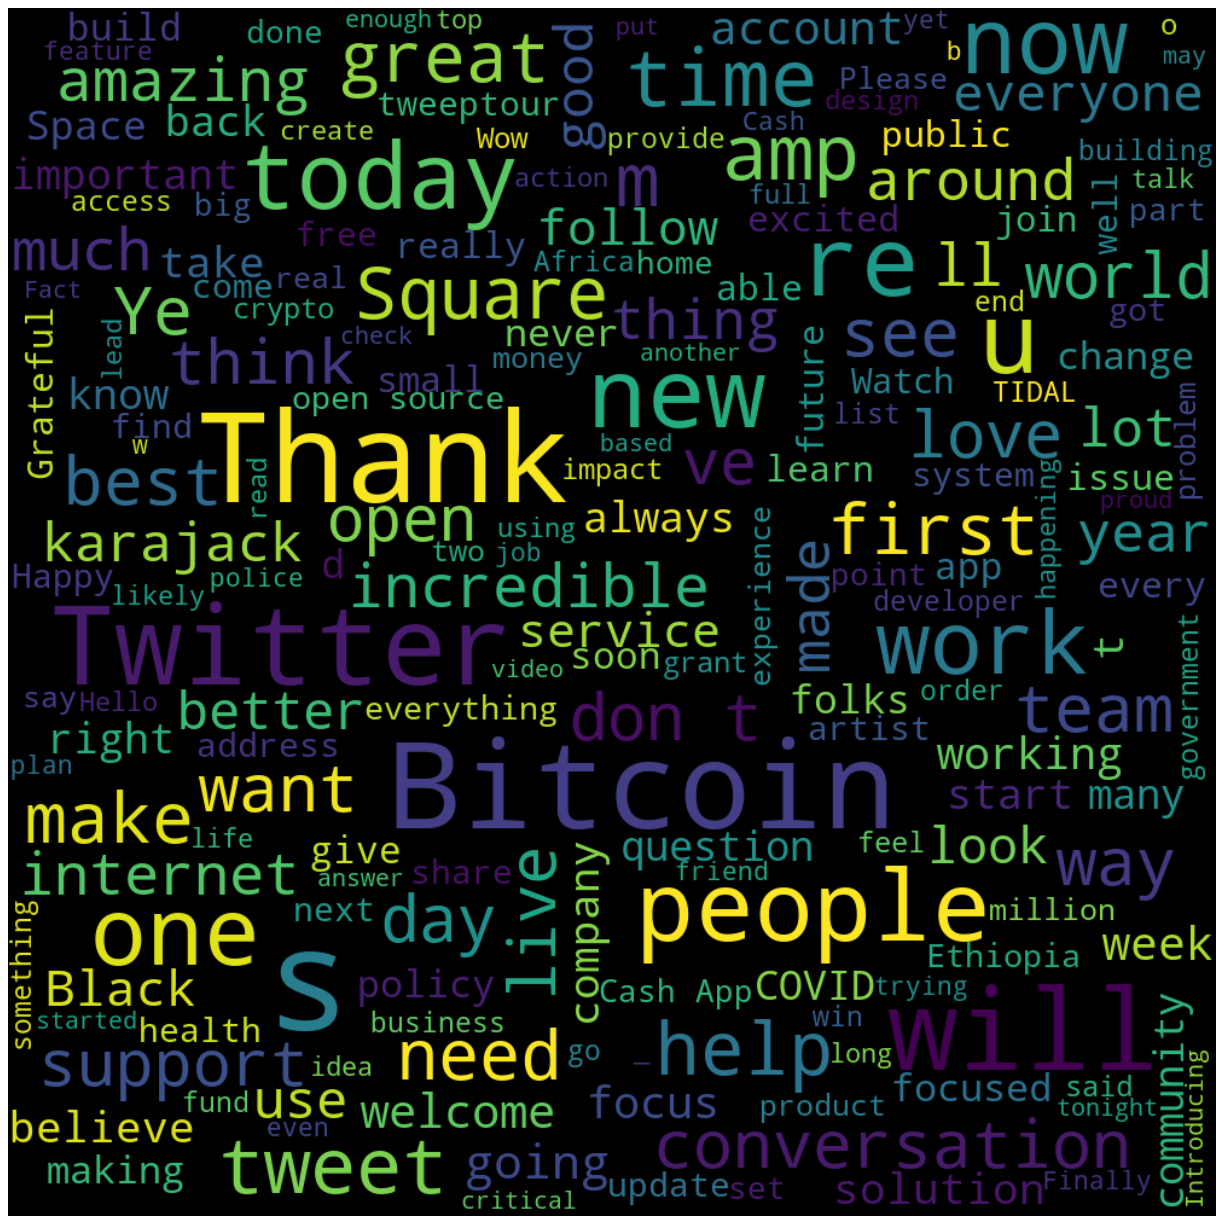

In [116]:
from wordcloud import WordCloud

allwords = " ".join([twts for twts in dorsey["full_text"]])
wordCloud = WordCloud(
    width=1000, height=1000, random_state=21, max_font_size=119
).generate(allwords)
plt.figure(figsize=(20, 20), dpi=80)
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [84]:
allwords = " ".join([twts for twts in dorsey["full_text"]])
sentiment = TextBlob(allwords).sentiment
print(sentiment)

Sentiment(polarity=0.2205014739805697, subjectivity=0.4956079205422524)


In [117]:
df_a.columns = [
    "Date",
    "agg_text",
    "agg_retweet",
    "agg_count",
    "subjectivity",
    "polarity",
]

In [121]:
d = df_a.iloc[:]["Date"]
d

0      2019-02-06
1      2019-02-07
2      2019-02-08
3      2019-02-09
4      2019-02-10
          ...    
707    2021-11-23
708    2021-11-24
709    2021-11-27
710    2021-11-28
711    2021-11-29
Name: Date, Length: 712, dtype: object

In [103]:
df = pd.merge(twitter, df_a, on="Date", how="outer")

In [104]:
df

,Date,Open,High,Low,Close,Adj Close,Volume,agg_text,agg_retweet,agg_count,subjectivity,polarity
0,2019-02-06,35.049999,35.250000,33.750000,34.160000,34.160000,34058000.0,Huh I believe so Thank youI love . It’s com...,1930.0,15392.0,0.599573,0.311418
1,2019-02-07,31.170000,31.730000,30.309999,30.799999,30.799999,69764100.0,! G N I Z a M A You’re amazing! Progress I do...,1589.0,3275.0,0.900000,0.750000
2,2019-02-08,30.469999,30.740000,29.420000,30.010000,30.010000,40669800.0,Live tweeting Live tweets. Anything a tweet ...,26212.0,3499.0,0.480871,0.085820
3,2019-02-11,30.170000,30.440001,29.660000,30.230000,30.230000,28838200.0,True Thanks! Maybe an error Good thing we ha...,4733.0,5253.0,0.429167,0.324847
4,2019-02-12,30.440001,30.799999,30.230000,30.389999,30.389999,20315300.0,"Go eat! Thanks, Kara karajack I don’t think y...",1084.0,9440.0,0.471228,0.164702
...,...,...,...,...,...,...,...,...,...,...,...,...
866,2021-11-13,NaN,NaN,NaN,NaN,NaN,NaN,: Woah Taproot support is already locked in on...,1428.0,8588.0,0.533333,0.320455
867,2021-11-14,NaN,NaN,NaN,NaN,NaN,NaN,": 15:39 @ 709,632709632 🎇",2343.0,19876.0,0.000000,0.000000
868,2021-11-20,NaN,NaN,NaN,NaN,NaN,NaN,"First draft of white paper is up, and on GitHu...",751.0,4795.0,0.166667,0.125000
869,2021-11-27,NaN,NaN,NaN,NaN,NaN,NaN,,1469.0,7489.0,0.000000,0.000000


In [95]:
df_a

,Date,agg_text,agg_retweet,agg_count,subjectivity,polarity
0,2019-02-06,Huh I believe so Thank youI love . It’s com...,1930,15392,0.599573,0.311418
1,2019-02-07,! G N I Z a M A You’re amazing! Progress I do...,1589,3275,0.900000,0.750000
2,2019-02-08,Live tweeting Live tweets. Anything a tweet ...,26212,3499,0.480871,0.085820
3,2019-02-09,Cool! They never answer for me No other coo...,103,801,0.452778,0.255208
4,2019-02-10,: 0x0fc425 Agree on,58,21,0.000000,0.000000
...,...,...,...,...,...,...
707,2021-11-23,: Today’s Speed Lesson: learn about the value ...,12166,2977,0.574204,0.242638
708,2021-11-24,: most nominated artist in the history of the ...,542,0,0.230000,0.050000
709,2021-11-27,,1469,7489,0.000000,0.000000
710,2021-11-28,I love twitter,11515,88222,0.600000,0.500000


In [99]:
twitter["Date"] = pd.to_datetime(twitter["Date"]).dt.date

In [100]:
twitter.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object